In [1]:
import pandas as pd
import xgboost as xgb
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import platform
from datetime import datetime, timedelta

def get_xgb_device(worker_id=0):
    """Determine best device for XGBoost."""
    try:
        import cupy as cp
        cp.cuda.Device(worker_id).use()
        print("Using CUDA (NVIDIA GPU)")
        return f"cuda:{worker_id}"
    except:
        pass

    if platform.processor() == "arm" or "Apple" in platform.processor():
        print("Using CPU with Apple Accelerate (M-series optimized)")
    else:
        print("Using CPU")

    return "cpu"

In [2]:
# Load Data
df = pd.read_parquet("historical_data_with_neighbors.parquet")
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values(by="date")

# Setup splits and filters similarly to model_setup.py
START_DATE = datetime(2025, 9, 8) + timedelta(days=28)
# df = df.loc[df["date"] >= START_DATE]
df = df.loc[df["grade"] > 6]
BAD_FEATURES = []
feature_cols = [
    col
    for col in df.columns
    if col not in ["gemrate_id", "date", "price"] and col not in BAD_FEATURES
]

TRAIN_TEST_SPLIT = 0.9

train_df = df.iloc[: int(len(df) * TRAIN_TEST_SPLIT)]
val_df = df.iloc[int(len(df) * TRAIN_TEST_SPLIT) :]

X_train = train_df[feature_cols]
y_train = train_df["price"]

X_val = val_df[feature_cols]
y_val = val_df["price"]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Training set: 368418 samples
Validation set: 40936 samples


In [3]:
# Load Hyperparameters
with open("model/results/worker_0_best.json", "r") as f:
    best_results = json.load(f)

params = best_results["best_params"]
print("Loaded parameters:", params)

Loaded parameters: {'max_depth': 24, 'n_estimators': 3000, 'min_child_weight': 7, 'subsample': 0.7451561628489454, 'colsample_bytree': 0.6182653550545925, 'learning_rate': 0.010838313984629559, 'gamma': 9.96408298134922e-05, 'reg_alpha': 3.0380532851235232e-09, 'reg_lambda': 8.717463876397597}


In [4]:
# Train Early Stopping Model
device = get_xgb_device(0)

es = xgb.callback.EarlyStopping(
    rounds=10,
    min_delta=1e-3,
    save_best=True,
    maximize=False,
    data_name="validation_0"
)

early_stop_model = xgb.XGBRegressor(
    device=device,
    objective='reg:squarederror',
    # tweedie_variance_power=1,
    callbacks=[es],
    n_jobs=-1,
    **params
)

print("Training early stopping model...")
early_stop_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)
print("Early stopping training complete.")

# Train Final Model on All Data
best_n_estimators = early_stop_model.best_iteration + 1
print(f"Best n_estimators: {best_n_estimators}")

# Update params with the best n_estimators
params["n_estimators"] = best_n_estimators

full_model = xgb.XGBRegressor(
    device=device,
    objective='reg:squarederror',
    n_jobs=-1,
    **params
)

print("Training final model on all data...")
# Combine train and val for full training
X_full = df[feature_cols]
y_full = df["price"]
full_model.fit(X_full, y_full, verbose=True)
print("Final training complete.")

Using CUDA (NVIDIA GPU)
Training early stopping model...
[0]	validation_0-rmse:957.09183
[1]	validation_0-rmse:951.73634
[2]	validation_0-rmse:947.44131
[3]	validation_0-rmse:942.59121
[4]	validation_0-rmse:937.70561
[5]	validation_0-rmse:932.85012
[6]	validation_0-rmse:928.51629
[7]	validation_0-rmse:923.74431
[8]	validation_0-rmse:919.20028
[9]	validation_0-rmse:914.87791
[10]	validation_0-rmse:910.22508
[11]	validation_0-rmse:905.87582
[12]	validation_0-rmse:901.50232
[13]	validation_0-rmse:897.28685
[14]	validation_0-rmse:892.91127
[15]	validation_0-rmse:889.28722
[16]	validation_0-rmse:885.18365
[17]	validation_0-rmse:881.05728
[18]	validation_0-rmse:876.89063
[19]	validation_0-rmse:872.76798
[20]	validation_0-rmse:868.75127
[21]	validation_0-rmse:864.81564
[22]	validation_0-rmse:861.11871
[23]	validation_0-rmse:857.33108
[24]	validation_0-rmse:853.84763
[25]	validation_0-rmse:850.06008
[26]	validation_0-rmse:846.46169
[27]	validation_0-rmse:842.96583
[28]	validation_0-rmse:839.63

/root/sync/ava/collector_crypt/.venv/lib/python3.13/site-packages/xgboost/core.py:774: UserWarning: [12:43:05] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


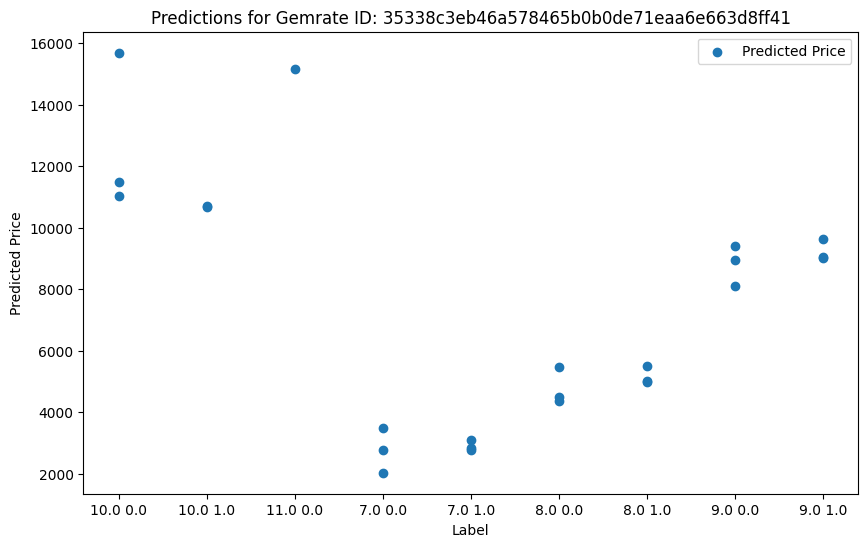

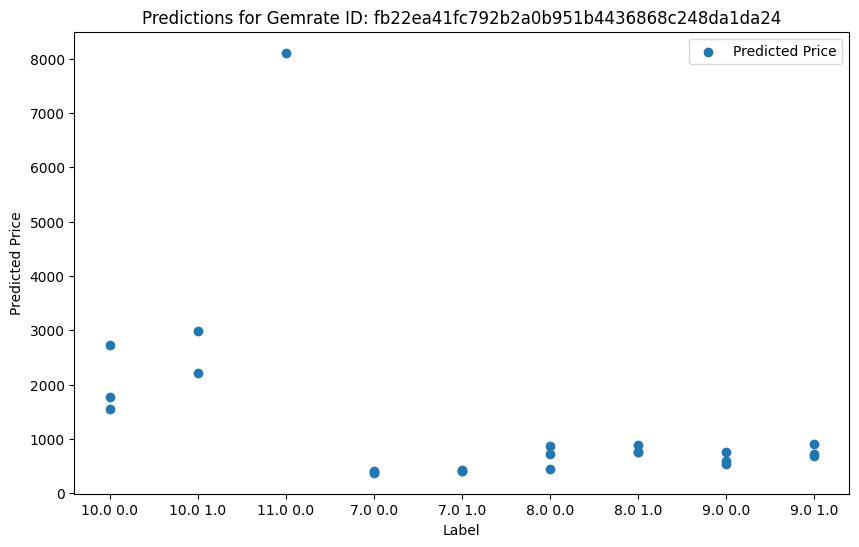

In [5]:
gemrate_ids = ["35338c3eb46a578465b0b0de71eaa6e663d8ff41", "fb22ea41fc792b2a0b951b4436868c248da1da24"]
test_df = pd.read_parquet("today_data_with_neighbors.parquet")
test_df = test_df.loc[test_df["gemrate_id"].isin(gemrate_ids)]
full_predictions = full_model.predict(test_df[feature_cols])
test_df["prediction"] = full_predictions



for gem_id in gemrate_ids:
    subset = test_df[test_df['gemrate_id'] == gem_id].copy()
    subset['label'] = subset['grade'].astype(str) + ' ' + subset['half_grade'].astype(str)
    subset = subset.sort_values("label")
    plt.figure(figsize=(10, 6))
    plt.scatter(subset['label'], subset['prediction'], label='Predicted Price')
    plt.title(f"Predictions for Gemrate ID: {gem_id}")
    plt.xlabel("Label")
    plt.ylabel("Predicted Price")
    plt.legend()
    plt.show()